In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.integrate import simpson
from scipy.optimize import nnls, lsq_linear
from sklearn.preprocessing import MinMaxScaler, StandardScaler

names = ['wn'] + [i for i in range(121)]

s1 = pd.read_csv('data/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)
s2 = pd.read_csv('data/S2_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

s1_intensities = simpson(s1[[i for i in range(121)]].values.T, s1.wn)
s2_intensities = simpson(s2[[i for i in range(121)]].values.T, s2.wn)

# normalization of the spectra
s1[[i for i in range(121)]] = s1[[i for i in range(121)]].div(s1_intensities, axis=1)
s2[[i for i in range(121)]] = s2[[i for i in range(121)]].div(s2_intensities, axis=1)

s1 = s1.T.rename(columns=s1.T.loc['wn'].map(int)).loc[0:]
s2 = s2.T.rename(columns=s2.T.loc['wn'].map(int)).loc[0:]

wn = s1.columns.map(float).values

In [96]:
sample_domain = np.loadtxt('data/S1_bkg_mapA_11x11.txt')[:, 0]
sample_spectra = np.loadtxt('data/S1_bkg_mapA_11x11.txt').T[1:]
sample_spectra = sample_spectra / simpson(sample_spectra, sample_domain)[:, None]
sample_spectra  - s1.values

array([[-2.71050543e-19, -2.71050543e-19, -2.71050543e-19, ...,
        -2.71050543e-19, -2.71050543e-19, -3.25260652e-19],
       [-1.89735380e-19, -1.62630326e-19, -1.89735380e-19, ...,
        -2.16840434e-19, -2.16840434e-19, -2.16840434e-19],
       [ 3.25260652e-19,  3.79470760e-19,  3.79470760e-19, ...,
         3.25260652e-19,  3.25260652e-19,  3.79470760e-19],
       ...,
       [-1.08420217e-19, -1.08420217e-19, -1.62630326e-19, ...,
        -3.25260652e-19, -4.33680869e-19, -3.25260652e-19],
       [-2.16840434e-19, -2.16840434e-19, -2.16840434e-19, ...,
        -4.06575815e-20, -4.06575815e-20, -2.71050543e-20],
       [-2.71050543e-19, -2.71050543e-19, -2.71050543e-19, ...,
        -4.33680869e-19, -4.33680869e-19, -4.33680869e-19]])

In [101]:
int_dom_ind = np.where((sample_domain > min(int_domain)) & 
                       (sample_domain < max(int_domain)))

In [100]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

reference_path = os.path.join('data', 'Database Raman')

labels  = []
domains = []
spectra = []

for filename in os.listdir(reference_path):
    # avoid non spectra files
    if sum(s.isupper() for s in filename) < 2:
        labels.append(filename.split('.')[0])

        filename = os.path.join(reference_path, filename)
        domains.append(np.loadtxt(filename)[:, 0])
        spectra.append(np.loadtxt(filename)[:, 1])

In [3]:
max_min = []
min_max = []
for domain in domains:
    max_min.append(domain[1])
    min_max.append(domain[-2])
    
np.max(max_min), np.min(min_max)

(226.1141, 1200.811)

In [42]:
max_wn_ind = np.where(wn == 1200)[0][0]
int_domain = wn[:max_wn_ind + 1]

int_spectra = np.zeros((len(spectra), max_wn_ind + 1))
for i, (domain, spectrum) in enumerate(zip(domains, spectra)):
    # avoid negative values (???)
    spectrum = np.where(spectrum < 0, 0, spectrum)
    int_spectra[i] = CubicSpline(domain[1:-1], spectrum[1:-1], extrapolate=False)(int_domain)
    int_spectra[i] = np.nan_to_num(int_spectra[i])
    int_spectra[i] = int_spectra[i] / simpson(int_spectra[i], int_domain)

scaler = MinMaxScaler().fit(int_spectra)
int_spectra = scaler.transform(int_spectra)

In [68]:
s1_renorm = s1.values[:, :max_wn_ind + 1] / simpson(s1.values[:, :max_wn_ind + 1], int_domain)[:, None]
s2_renorm = s2.values[:, :max_wn_ind + 1] / simpson(s2.values[:, :max_wn_ind + 1], int_domain)[:, None]

s1_renorm = scaler.transform(s1_renorm)
s2_renorm = scaler.transform(s2_renorm)

In [ ]:
### non_zero = []
labels_dist = []
residuals = []
lss = []
X = np.zeros((121, 61))

for i in range(121):
    ls, res = nnls(int_spectra.T, s1_renorm[i], maxiter=1000)
    lss.append(ls / np.sum(ls))
    residuals.append(res)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
#     ax1.plot(int_domain, s1_renorm[i], label='original')
#     ax1.plot(int_domain, int_spectra.T.dot(ls), label='reconstructed')
#     ax1.legend()
#     ax1.grid()

#     ax2.scatter(np.arange(1, 62), ls / np.sum(ls))
#     ax2.grid()

#     plt.show()

    ls = np.where((ls / np.sum(ls)) <= .2, 0, ls)
    
    labels_dist.append(np.sum(np.nonzero(ls)[0]))
    non_zero.append(np.nonzero(ls)[0].shape[0])
    X[i] = ls / np.sum(ls)

X = np.nan_to_num(X, nan=-1)

In [80]:
non_zero = np.array(non_zero)
lss = np.array(lss)
residuals = np.array(residuals)
labels_dist = np.array(labels_dist)

In [81]:
round(np.where((non_zero > 0) & (non_zero < 4) & (residuals < 3))[0].shape[0] / residuals.shape[0], 3)

0.595

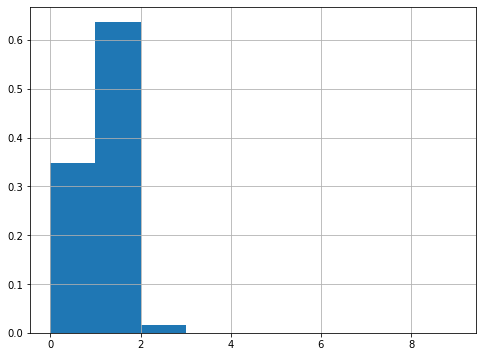

In [82]:
plt.hist(non_zero, bins=np.arange(10), density=True)
plt.grid()

1.8536445601977063 0.39851135148935807


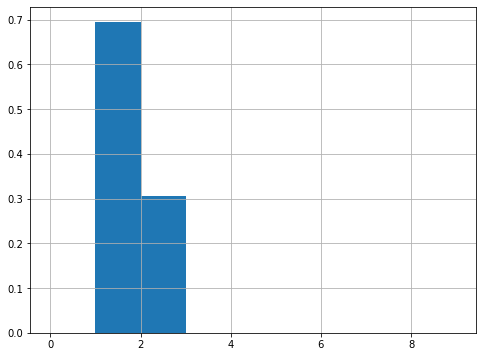

In [83]:
res_ind = np.where((non_zero > 0) & (residuals < 3))[0]
print(np.mean(residuals[res_ind]), np.std(residuals[res_ind]))
plt.hist(residuals[res_ind], bins=np.arange(10), density=True)
plt.grid()

8


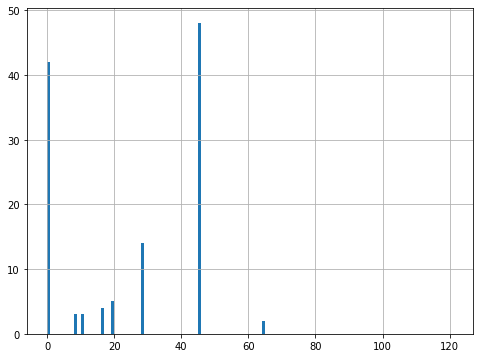

In [84]:
print(len(set(labels_dist)))
np.where((non_zero > 0) & (non_zero < 4) & (residuals < 3))[0].shape[0] / residuals.shape[0]
plt.hist(labels_dist, bins=np.arange(122))
plt.grid()

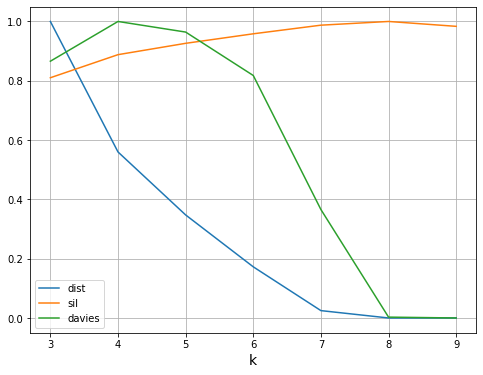

In [90]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

distortions = []
silhouette = []
davies = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10000, tol=1e-6, random_state=0).fit(X)
    labels = kmeans.labels_
    distortions.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))
    davies.append(davies_bouldin_score(X, labels))

#     print(k, round(calinski_harabasz_score(X, labels), 5), 
#              round(silhouette_score(X, labels), 5),
#              round(davies_bouldin_score(X, labels), 5))

plt.plot(np.arange(3, 10), np.array(distortions) / max(distortions), label='dist')
plt.plot(np.arange(3, 10), np.array(silhouette) / max(silhouette), label='sil')
plt.plot(np.arange(3, 10), np.array(davies) / max(davies), label='davies')
plt.xlabel('k', fontsize=14)
plt.legend()
plt.grid()

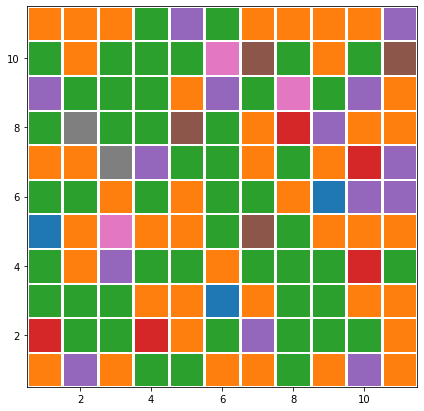

In [91]:
x, y = np.meshgrid(np.arange(1, 12), np.arange(1, 12))

label_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:cyan',
}

plt.figure(figsize=(7, 7))
kmeans = KMeans(n_clusters=8, max_iter=10000, tol=1e-6, random_state=0).fit(X)
labels = kmeans.predict(X)

colors = np.array([label_to_color[i] for i in labels])

plt.scatter(x, y, c=colors, s=1000, marker='s')
plt.show()